### 1. Data Importing and Pre-processing
#### **Import dataset and describe characteristics such as dimensions, data types, file types, and import methods used**

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#import the file using pandas reader
df=pd.read_csv('online_shoppers_intention.csv', header=0)

In [3]:
#read column headers, data types, and data shape
#df.head(5)

In [4]:
#df.dtypes #reading the data types

In [5]:
#print('Number of rows in data set:',df.shape[0])
#print('Number of columns in data set:',df.shape[1])

#### **Clean, wrangle, and handle missing data**

In [6]:
#identify amount of NA data by column
#print(df.isnull().sum())

In [7]:
#Investigating the informational column first. Hypothesis is that Informational and Informational_Duration are connected in that 
#Informational is a categorical variable and Informational_Duration provides the time spent on an informational page. Therefore, if
#Informational_Duration = 0, Informational should equal 0. If they are not 0, may need to replace with mode. 
#First, look at the null values of informational column: 
#df_info_null=df[df['Informational'].isnull()]
#df_infodur_0=df_info_null['Informational_Duration']
#df_infodur_0.value_counts()

In [8]:
#Seeing here that null values for Informational do span both 0 and non-zero Info_Duration values. Investigating 0 values next:
#filter the data frame for just Info = 0 values
df_infodur_0=df[df['Informational_Duration']==0]

In [9]:
info_value0=df_infodur_0['Informational']

In [10]:
#find the unique values and their counts of Informational when Info_Duration = 0
#info_value0.value_counts()

In [11]:
#Investigating the other direction: when Informational = 0, are their non-0 values of Info_Duration?
#df_info0=df[df['Informational']==0]
#info_dur0=df_info0['Informational_Duration']
#info_dur0.value_counts()

In [12]:
df_info_not0=df[df['Informational_Duration']>0] #create a dataframe of rows with non-zero Info_Duration 
info_mode_not0=df_info_not0['Informational'].mode() #find the mode of this dataframe
info_mode_not0

0    1.0
Name: Informational, dtype: float64

In [13]:
#Given the above infomation, the vast majority of Info and Info_Duration 0/0 values and the non-zero mode of 1, 
#concluding that it is best to fill with differing mode values depending on the Informational_Duration column
#i.e: if Informational Duration = 0, fill NaN values with 0 (mode). if Informational Duration >0, fill NaN values with 1 (non zero mode)

In [14]:
#locate the lines where Informational is null and Info_Duration is 0:
df_info_00=df.loc[(df['Informational'].isnull())&(df['Informational_Duration']==0)]

In [15]:
#df_info_00.head(5) #checking

In [16]:
#fill only null informational values with 0 (mode) if Info Duration is 0
df.loc[(df['Informational_Duration']==0) & (df['Informational'].isna()), 'Informational']=0

In [17]:
#check to see this filled some null values
#df.isna().sum()

In [18]:
#fill rest of informational values with non-0 (mode) if Info Duration is >0 (see variable info_mode_not0)
df.loc[(df['Informational_Duration']>0) & (df['Informational'].isna()), 'Informational']= 1

In [19]:
#check to see this filled the null values
#df.isna().sum()

In [20]:
#next, investigating Page Values for filling NA:
#df['PageValues'].nunique()

In [21]:
#There are 2,681 unique values with Page Values. According to the notes on the data, "The "Page Value" feature represents the average 
#value for a web page that a user visited before completing an e-commerce transaction." 
#We do not know how "value" was determined. Opting to fill with mode given the column representation is unknown
#df['PageValues'].mode()

In [22]:
#checking to see if a dual mode makes sense for this column as well - if Revenue is False, is PageValue 0?
#rev_false=df[df['Revenue']==False]
#rev_false['PageValues'].nunique()
#no - Page Value can still have 1183 different values if Rev=False. Continuing with applying mode for full column

In [23]:
#checking how many rows have a zero value for PageValues
#len(df[df['PageValues']==0])

In [24]:
#fill null PageValues with 0
df.loc[df['PageValues'].isna(), 'PageValues']= 0

In [25]:
#df.isna().sum()

In [26]:
#df.head(5)

In [27]:
#see how many unique values and their respective value counts exist for OperatingSystems
#df['OperatingSystems'].value_counts()

In [28]:
#see how many unique values and their respective value counts exist for OperatingSystems
#df['Browser'].value_counts()

In [29]:
#understand if there is a correlation between Operating System and Browser
#correlation = df['OperatingSystems'].corr(df['Browser'])

In [30]:
#correlation

In [31]:
#too weak of a correlation, will use mode for Operating system as well
#df['OperatingSystems'].mode()

In [32]:
#Filling Operating Sysem NAs with mode
df.loc[df['OperatingSystems'].isna(), 'OperatingSystems']= 2.0

In [33]:
#checking to see all NAs are filled 
#df.isna().sum()

#### **Transform data appropriately using techniques such as aggregation, normalization, and feature construction**

In [34]:
#combine _duration columns (aggregation)
df['Total_Duration'] = (
    df['Administrative_Duration']+
    df['Informational_Duration']+
    df['ProductRelated_Duration']
)

In [35]:
# z scaling (normalization)
standard_cols = ['BounceRates', 'ExitRates', 'PageValues']

means=df[standard_cols].mean()
stds=df[standard_cols].std(ddof=0)  # ddof=0 matches sklearn's StandardScaler

#apply Z-score scaling: (x - mean) / std
df[standard_cols] = (df[standard_cols] - means) / stds

#verify Z-scaling
check = pd.DataFrame({
    'mean': df[standard_cols].mean(),
    'std': df[standard_cols].std(ddof=0)
})
check

,mean,std
BounceRates,-3.688137e-17,1.0
ExitRates,-1.336950e-16,1.0
PageValues,6.454241e-17,1.0


In [36]:
#feature construction: engagement level

#classify engagement level based on newly aggregated total duration value
df['Engagement_Level'] = pd.cut(
    df['Total_Duration'],
    bins=[0,60,300,1200, df['Total_Duration'].max()],
    labels=['Very Low', 'Low', 'Medium', 'High'],
    include_lowest=True
)

In [37]:
#feature construction: special purchase
#print(df['SpecialDay'].unique())
#if special day >0 & Revenue = true, special purchase will be true

In [38]:
def SpecialPurpose(row):
    if row['Revenue'] == True and row['SpecialDay'] >0:
        return True
    else:
        return False

In [39]:
df['SpecialPurchase'] = df.apply(SpecialPurpose, axis=1)

In [40]:
#df.head(3) #checking column additionss

#### **Reduce redundant data and perform need-based discretization**

In [41]:
#considering eliminating "PageValue"
#about page value: The "Page Value" feature represents the average value for a web page 
#that a user visited before completing an e-commerce transaction. 

In [42]:
#print(df['PageValues'].value_counts())
#df['PageValues'].nunique()
#print(df['Revenue'].value_counts())
#PageValues, without the key, is not providing usable information without knowing more about the page valuations. Will remove for this analysis

In [43]:
#df.head(3)

In [44]:
#Similarly, Operating System and Browser are not relevant at this point

In [45]:
#df['Administrative'].unique()
#df_admin0=df[df['Administrative_Duration']>0]
#df_admin0['Administrative'].unique()
#if administrative_duration is 0, administrative is also 0. Without information on the 
#page categories value, this information is duplicative

In [46]:
#df['Informational'].unique()
#df_info0=df[df['Informational_Duration']>0]
#df_info0['Informational'].unique()
#same situation as administrative

In [47]:
#df['ProductRelated'].unique()
#df_product0 = df[df['ProductRelated_Duration']>0]
#df_product0['ProductRelated'].unique()
#found that the same information is told but Product_Duration=0 is coded to Product=1 (instead of 0 like the other columns) 
#Without knowing the product coding for this categorical column I would also delete as it is duplicative

In [48]:
#drop columns that were decided not to have information necessary for the analysis
df_clean = df.drop(['PageValues','OperatingSystems','Browser','Administrative', 'Informational','ProductRelated'],axis='columns')
#df_clean.head(2)

### 2. Data Analysis and Visualizations

#### **Identify categorical, ordinal, and numerical variables within the data**

In [49]:
#reviewing data types
#df_clean.dtypes

In [50]:
#confirmed that all _Duration columns as well as BounceRates, ExitRates should be numerical
#Special Day should be recoded to categorical as it seems to be specifying a certain holiday based on the number/key
#Region is also categorical to a key
#understanding other columns: 
#"Traffic Type" column
#df['TrafficType'].unique() #this looks to be a categorical variable to a key

In [51]:
#region and traffic type are both categorical variables. changing the data types to categorical
df_clean['Region']=df_clean['Region'].astype('category')
#df_clean.dtypes #checking

In [52]:
df_clean['TrafficType']=df_clean['TrafficType'].astype('category')
df_clean['SpecialDay']=df_clean['SpecialDay'].astype('category')
#df_clean.dtypes

#### **Provide measures of centrality and distribution with visualizations**

In [53]:
num_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'Total_Duration'
    # leaving out exit rates and bounce rates as the z scaling creates plotting issues. They will still be used in correlation analysis and modeling but no need to plot them
]
#pd.set_option('display.float_format', '{:.4f}'.format)


df_clean[num_cols].describe()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,Total_Duration
count,12330.000000,12330.000000,12330.000000,12330.000000
mean,80.818611,34.472398,1194.746220,1310.037228
std,176.779107,140.749294,1913.669288,2037.801702
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,184.137500,222.000000
50%,7.500000,0.000000,598.936905,680.000000
75%,93.256250,0.000000,1464.157214,1626.908333
max,3398.750000,2549.375000,63973.522230,69921.647230


In [54]:
#df_clean[num_cols].hist(figsize=(12, 8), bins=30)
#plt.suptitle("Distributions of Numerical Features", fontsize=14)
#plt.tight_layout()
#plt.show()
#not the best viz method for this data. Tried boxplot next


In [55]:
#plt.figure(figsize=(12, 6))
#sns.boxplot(data=df_clean[num_cols])
#plt.title("Boxplots of Session Durations")

#plt.xlabel("Session Type")

#plt.ylabel("Seconds")

#plt.xticks(rotation=45)
#plt.show()
#clipped version in next cell


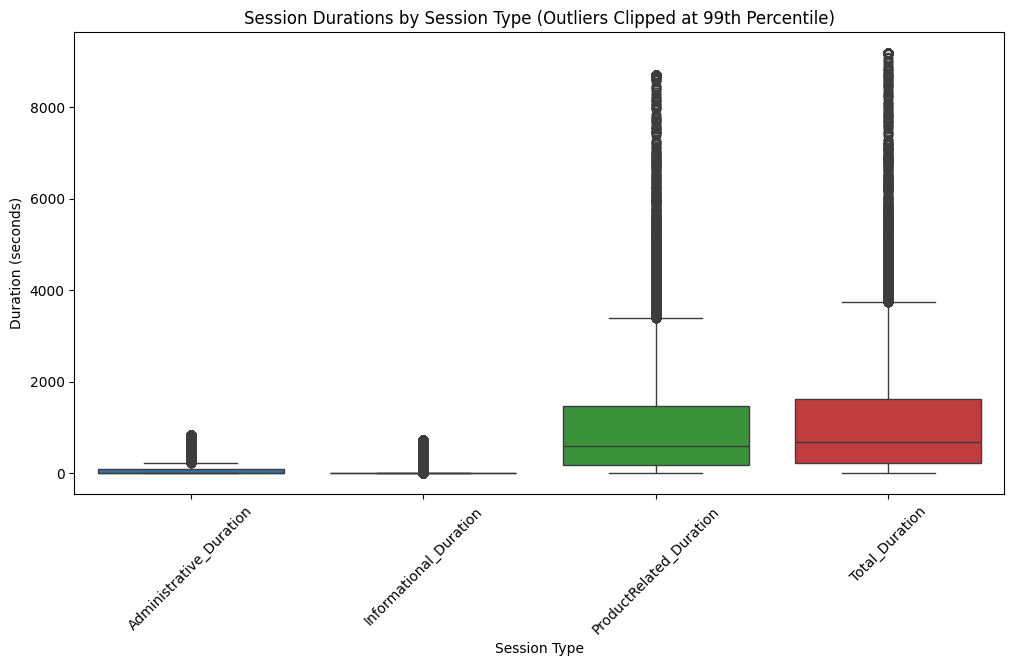

In [56]:
# Create a viz copy
df_viz = df_clean.copy()

# Clip extreme outliers
for col in num_cols:
    df_viz[col] = df_viz[col].clip(upper=df_clean[col].quantile(0.99))

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_viz[num_cols])
plt.title("Session Durations by Session Type (Outliers Clipped at 99th Percentile)")
plt.xlabel("Session Type")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.show()


#### **Diagnose for correlations between variables and determine independent and dependent variables**

In [57]:
corr = df_clean.corr(numeric_only=True)
corr


,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,Weekend,Revenue,Total_Duration,SpecialPurchase
Administrative_Duration,1.000000,0.238031,0.355422,-0.144170,-0.205798,0.014990,0.093587,0.436962,-0.008294
Informational_Duration,0.238031,1.000000,0.347364,-0.074067,-0.105276,0.024078,0.070345,0.415922,0.017110
ProductRelated_Duration,0.355422,0.347364,1.000000,-0.184541,-0.251984,0.007311,0.152373,0.993910,0.004131
BounceRates,-0.144170,-0.074067,-0.184541,1.000000,0.913004,-0.046514,-0.150673,-0.190922,-0.025292
ExitRates,-0.205798,-0.105276,-0.251984,0.913004,1.000000,-0.062587,-0.207071,-0.261759,-0.035446
Weekend,0.014990,0.024078,0.007311,-0.046514,-0.062587,1.000000,0.029295,0.009829,-0.019276
Revenue,0.093587,0.070345,0.152373,-0.150673,-0.207071,0.029295,1.000000,0.156068,0.185272
Total_Duration,0.436962,0.415922,0.993910,-0.190922,-0.261759,0.009829,0.156068,1.000000,0.004342
SpecialPurchase,-0.008294,0.017110,0.004131,-0.025292,-0.035446,-0.019276,0.185272,0.004342,1.000000


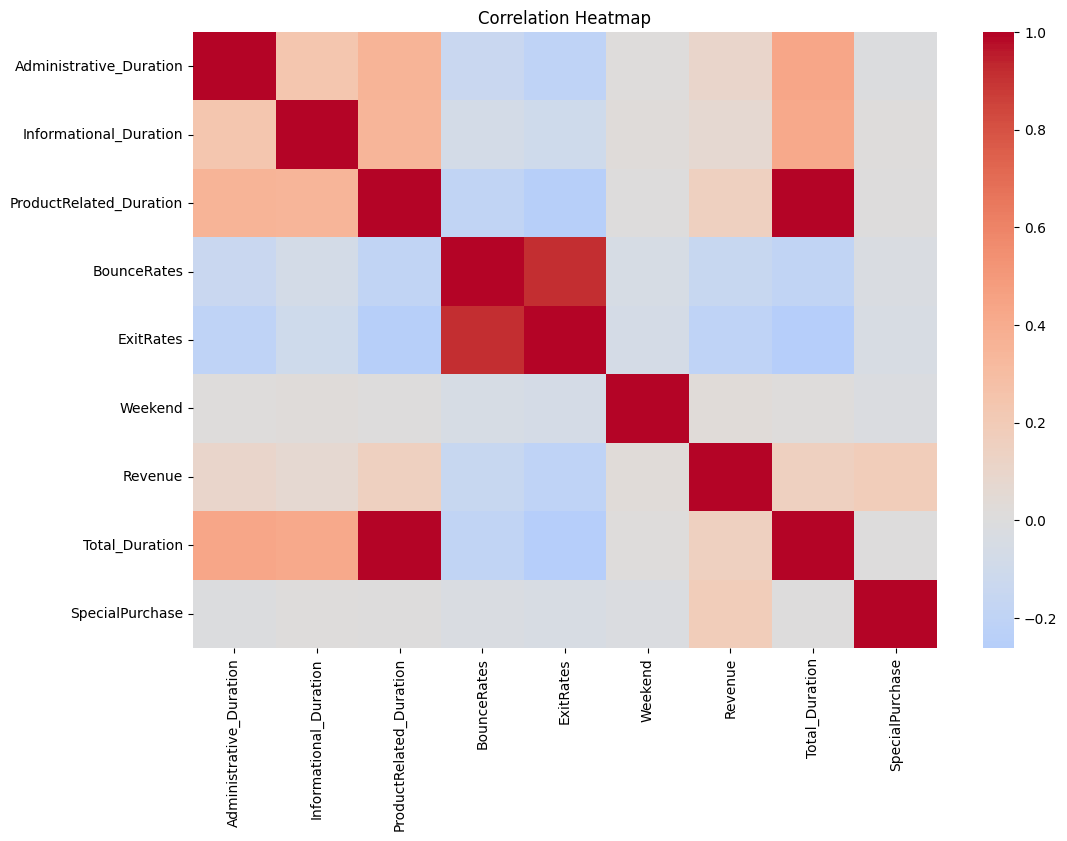

In [58]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False,cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()


In [59]:
#revenue is the dependent variable, the rest of the output are the independent variables
corr_with_revenue = corr['Revenue'].sort_values(ascending=False)
#corr_with_revenue


In [60]:
#these are the independent variable with the strongest correlations
top_predictors = corr_with_revenue[abs(corr_with_revenue) > 0.1]
#top_predictors

#### **Perform exploratory analysis in combination with visualization techniques to discover patterns and features of interest**

In [61]:
df_clean.head(5)

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,SpecialDay,Month,Region,TrafficType,VisitorType,Weekend,Revenue,Total_Duration,Engagement_Level,SpecialPurchase
0,0.0,0.0,0.000000,3.667189,3.229316,0.0,Feb,1,1,Returning_Visitor,False,False,0.000000,Very Low,False
1,0.0,0.0,64.000000,-0.457683,1.171473,0.0,Feb,1,2,Returning_Visitor,False,False,64.000000,Low,False
2,0.0,0.0,0.000000,3.667189,3.229316,0.0,Feb,9,3,Returning_Visitor,False,False,0.000000,Very Low,False
3,0.0,0.0,2.666667,0.573535,1.994610,0.0,Feb,2,4,Returning_Visitor,False,False,2.666667,Very Low,False
4,0.0,0.0,627.500000,-0.045196,0.142551,0.0,Feb,1,4,Returning_Visitor,True,False,627.500000,Medium,False


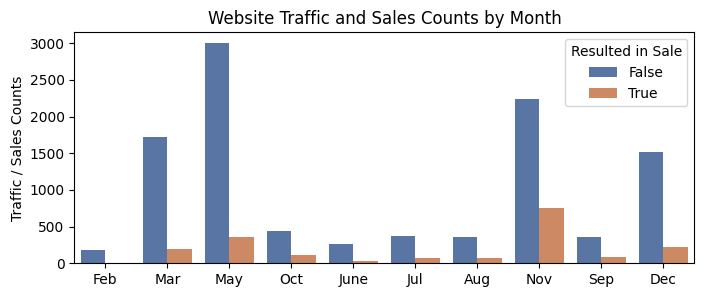

In [62]:
#look at how website traffic changes by month, and which months result in the most sales
plt.figure(figsize=(8,3))
sns.countplot(data=df_clean, x='Month', hue='Revenue', palette='deep')
plt.xlabel("")
plt.ylabel("Traffic / Sales Counts")
plt.title("Website Traffic and Sales Counts by Month")
plt.legend(title="Resulted in Sale")
plt.show()

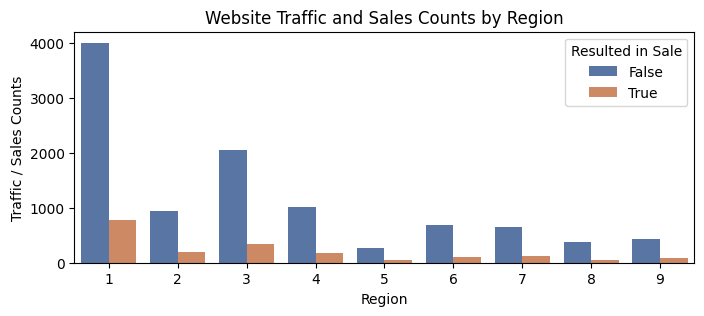

In [63]:
#look next at website traffic and sales counts by region
plt.figure(figsize=(8,3))
sns.countplot(x='Region', hue='Revenue',data =df_clean, palette='deep')
plt.xlabel("Region")
plt.ylabel("Traffic / Sales Counts")
plt.title("Website Traffic and Sales Counts by Region")
plt.legend(title="Resulted in Sale")
plt.show()

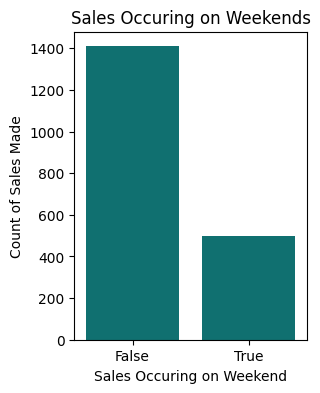

In [64]:
#understand if sales primarily occur on weekends or weekdays
df_rev=df_clean[df_clean['Revenue']]
df_clean['Revenue'] = df_clean['Revenue'].astype(bool)
plt.figure(figsize=(3,4))
ax=sns.countplot(x='Weekend', data =df_rev, color='teal')
ax.set_xlabel("Sales Occuring on Weekend")
ax.set_ylabel("Count of Sales Made")
plt.title("Sales Occuring on Weekends")
plt.show()

In [65]:
df_rev.head(5)
df_rev.dtypes

Administrative_Duration     float64
Informational_Duration      float64
ProductRelated_Duration     float64
BounceRates                 float64
ExitRates                   float64
SpecialDay                 category
Month                        object
Region                     category
TrafficType                category
VisitorType                  object
Weekend                        bool
Revenue                        bool
Total_Duration              float64
Engagement_Level           category
SpecialPurchase                bool
dtype: object

In [66]:
df_rev['SpecialDay'].unique()

[0.8, 0.0, 1.0, 0.6, 0.2, 0.4]
Categories (6, float64): [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

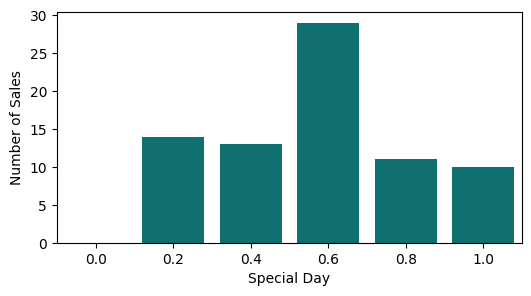

In [67]:
#See which holiday encourages the most sales
df['SpecialDay'].unique()
plt.figure(figsize=(6,3))
df_rev_special = df_rev[df_rev['SpecialDay'].astype(float) > 0]
ax1=sns.countplot(x='SpecialDay', data=df_rev_special, color='teal')
ax1.set_xlabel("Special Day")
ax1.set_ylabel("Number of Sales")
plt.show()

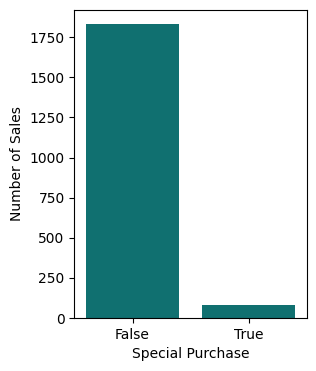

In [68]:
#understand if "special days" are a main driver of sales
plt.figure(figsize=(3,4))
ax2=sns.countplot(x='SpecialPurchase', data=df_rev, color='teal')
ax2.set_xlabel("Special Purchase")
ax2.set_ylabel("Number of Sales")
plt.show()

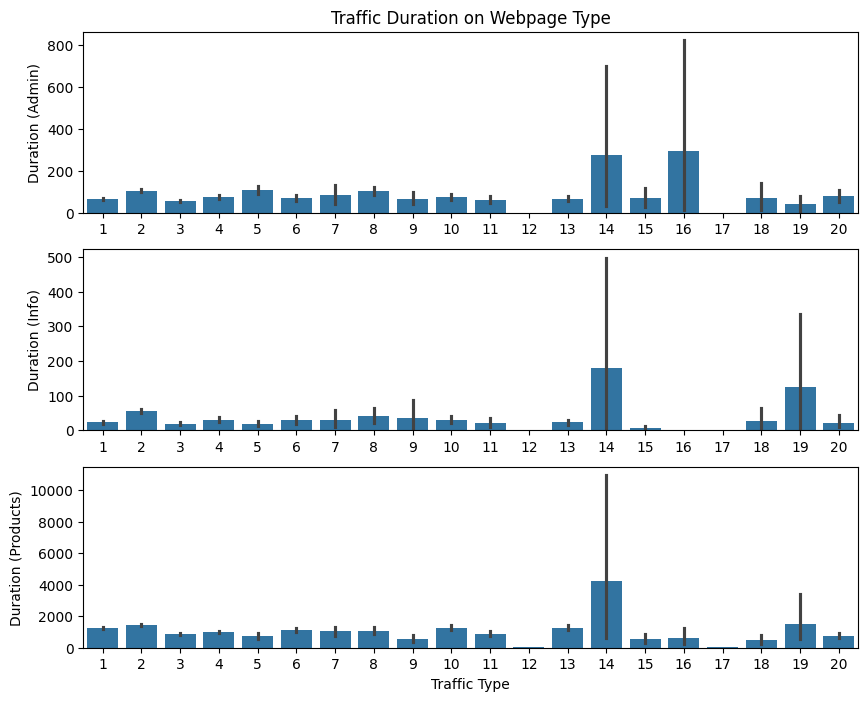

In [69]:
#learn more what "Traffic Type" might mean:
fig, axes = plt.subplots(3,1, figsize= (10,8))
sns.barplot(x='TrafficType', y='Administrative_Duration', data=df_clean, ax=axes[0])
axes[0].set_title('Traffic Duration on Webpage Type')
axes[0].set_xlabel("")
axes[0].set_ylabel("Duration (Admin)")
sns.barplot(x='TrafficType', y='Informational_Duration', data=df_clean, ax=axes[1])
#axes[1].set_title('Traffic Duration on Informational Site')
axes[1].set_xlabel("")
axes[1].set_ylabel("Duration (Info)")
sns.barplot(x='TrafficType', y='ProductRelated_Duration', data=df_clean, ax=axes[2])
#axes[2].set_title('Traffic Duration on Product-Related Site')
axes[2].set_xlabel("Traffic Type")
axes[2].set_ylabel("Duration (Products)")
plt.show()
#this is not very conclusive. 

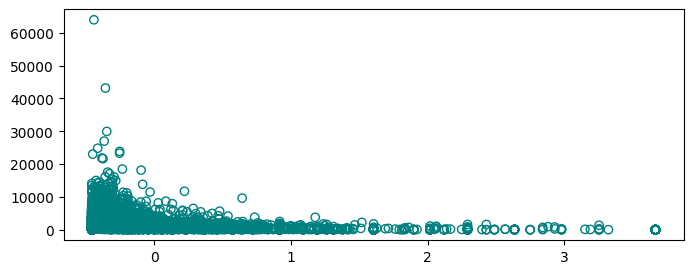

In [70]:
#explore how exit or bounce rates may be related to duration
plt.figure(figsize=(8,3))
#plt.scatter(df_clean['BounceRates'], df_clean['Administrative_Duration'], marker='s', facecolor='none', edgecolor='gold')
#plt.scatter(df_clean['ExitRates'], df_clean['Informational_Duration'], marker='o', facecolor='none', edgecolor='teal')
plt.scatter(df_clean['BounceRates'], df_clean['ProductRelated_Duration'], marker='o', facecolor='none', edgecolor='teal')
#plt.scatter(df_clean['BounceRates'], df_clean['Total_Duration'], marker='o', facecolor='none', edgecolor='teal')
plt.show()

#### Determine the need for a supervised or unsupervised learning method and identify dependent and independent variables
The analytical scenario we will create a model for is determining whether or not a user will complete a purchase. To do this, a supervised model, specifically a logistic regression model, will be used to predict an outcome variable (dependent variable) of "yes" or "no" for whether or not a purchase was predicted. 
#### Train, test, and provide accuracy and evaluation metrics for model results

In [77]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [120]:
df_clean.shape

(12330, 17)

In [121]:
df_clean.head(3)
#create new column for encoded labels for model
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_clean['VisitorEncoded']=le.fit_transform(df_clean['VisitorType'])
df_clean.head(3) #check
df_clean['WeekendEncoded']=le.fit_transform(df_clean['Weekend'])
#df_clean.head(3) #check

In [122]:
df_model = df_clean.iloc[:,[0,1,2,3,4,5,7,8,15,16,11]] #pulling relevant columns to new datafram
df_model.head(3) #checking

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,SpecialDay,Region,TrafficType,VisitorEncoded,WeekendEncoded,Revenue
0,0.0,0.0,0.0,3.667189,3.229316,0.0,1,1,2,0,False
1,0.0,0.0,64.0,-0.457683,1.171473,0.0,1,2,2,0,False
2,0.0,0.0,0.0,3.667189,3.229316,0.0,9,3,2,0,False


In [123]:
#split the data into training and test data sets
X = df_model.iloc[:,0:9] #pulling first 12 columns, before revenue
y = df_clean.iloc[:,10] #pulling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)
model = LogisticRegression()

In [124]:
#train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [127]:
y_pred_prob = model.predict_proba(X_test)[:,1]
accuracy = accuracy_score(y_test, y_pred) #accurancy score on test data

In [128]:
accuracy

0.7766964044336307

In [133]:
#confusion matrix (how predictions map to actual values)
conf_matrix = confusion_matrix(y_test, y_pred)
# [[True Negatives (TN), False Positives (FP)]
#  [False Negatives (FN), True Positives (TP)]]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.78      1.00      0.87      2874
        True       0.00      0.00      0.00       825

    accuracy                           0.78      3699
   macro avg       0.39      0.50      0.44      3699
weighted avg       0.60      0.78      0.68      3699



In [134]:
# D. Model Coefficients (Interpretability)
print("\nModel Coefficients (Weights):")
# Coefficients indicate the importance and direction of the feature's influence
# A positive coefficient means the feature increases the probability of class 1.
print(f"Feature 1 Weight (Exam Score 1): {model.coef_[0][0]:.4f}")
print(f"Feature 2 Weight (Exam Score 2): {model.coef_[0][1]:.4f}")
print(f"Intercept (Bias): {model.intercept_[0]:.4f}")


Model Coefficients (Weights):
Feature 1 Weight (Exam Score 1): -0.0002
Feature 2 Weight (Exam Score 2): 0.0005
Intercept (Bias): -0.2881
